In [26]:
#импорт библиотек для работы
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from scipy.stats import levene

In [3]:
#чтение и запись данных для работы
dating_data_df = pd.read_csv('../AB test/dating_data.csv')

In [4]:
dating_data_df.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


## Предварительный анализ данных

In [5]:
#проверим на наличие пропущенных данных 
dating_data_df.isnull().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

In [7]:
#посмотрим, сколько уникальных значений содержится в колонке user_id_1 и user_id_2
print('Переменная user_id_1 содержит', dating_data_df['user_id_1'].nunique(), 'уникальных значений')
print('Переменная user_id_2 содержит', dating_data_df['user_id_2'].nunique(), 'уникальных значений')

Переменная user_id_1 содержит 1000 уникальных значений
Переменная user_id_2 содержит 1000 уникальных значений


In [22]:
#проверим, совпадает ли набор значений в столбце user_id_1 со значениями из user_id_2
if dating_data_df['user_id_1'].sort_values().reset_index(drop=True).equals(dating_data_df['user_id_2'].sort_values().reset_index(drop=True)):
    print("Значения совпадают")
else:
    print("Значения не совпадают")

Значения не совпадают


In [10]:
# проверим отсутствие случаев, когда в одной строке одновременно совпадают значения в колонке user_id_1 и user_id_2
#пользователь метчится с другим пользователям, не с самим собой
def rule(id):
    if id[0] == id[1]:
        return 'Есть совпадения'
    else:
        return 'Нет совпадений'
dating_data_df.apply(rule)

user_id_1     Нет совпадений
user_id_2     Нет совпадений
group        Есть совпадения
is_match     Есть совпадения
dtype: object

In [11]:
#посмотрим, сколько уникальных пользователей принадлежат к каждой группе:
# 0 = старые алгоритмы, 1 = новые алгоритмы
dating_data_df.groupby('group', as_index=False) \
              .agg({'user_id_1':'nunique'}) \
              .rename(columns={'user_id_1':'sum_values'})

,group,sum_values
0,0,501
1,1,499


### Описание наших данных
Всего у нас 1 000 уникальных пользователей приложения, которые участвовали в AB тестировании. Будем считать, что каждое уникальное значение в  колонке user_id_1 и user_id_2 - это уникальный id нашего пользователя. Колонка user_id_1 - в ней сохранены те пользователи, которые ставят лайк/дизлайк пользователям в колонке user_id_2 и мы используем ее в анализе

group - к какой группе принадлежит пользователь. 0 - пользователи, которые используют приложение со старым алгоритмом (контрольная группа). 1 - пользователи, которые используют приложение с новым алгоритмом (тестируемая группа). В контрольной группе у нас 501 пользователей, в тестируемой 499 пользователей. 

is_match = 0, то мэтч между двумя пользователями не произошел, is_match = 1, пользователи поставили друг другу взаимные лайки (произошел мэтч).

## Метрики и гипотезы 

Основная цель нашего тестирования - оценка нового алгоритма и правда ли он улучшил качество сервиса. Нашим сервисом является приложение для онлайн-знакомства, где конечная цель пользователя - познакомиться с другим пользователем. Исходя из этого и механики приложение (пользователи ставят лайки или дизлайки), то целевой метрикой нашего приложения будет соотношение мэтчей ко всем лайкам пользователя (процент мэтчей). Дополнительной метрикой -  количество активностей на 1 пользователя (независимая от долей мэтчей метрика). 

Наши продуктовые гипотезы - 
1. Новый алгоритм предлагает пользователям более подходящие анкеты, чем старый алгоритм. Это увеличило соотношение мэтчей ко всем лайкам за счет того, что пользователи получали взаимный лайк от других быстрее (им требовалось меньше действий, чем пользователям из контрольной группы). 
2. Благодаря новому алгоритму среднее число активностей на пользователя увеличилось

**Рассмотрим статистику по нашим метрикам для пользователей контрольной и тестовых групп - соотношение мэтчей ко всем лайкам и количество активностей** 

Пользователи из контрольной группы, которые используют приложение со старым алгоритмом

In [12]:
likes_users_0 = dating_data_df.query('group == 0') \
              .groupby('user_id_1', as_index=False) \
              .agg({'user_id_2':'count', 'is_match':'sum'}) \
              .rename(columns={'user_id_2':'likes_0', 'is_match':'is_match_0'}) \
              .assign(perc_match_0 = lambda x: x['is_match_0'] / x['likes_0'] * 100).round(2) \
              .sort_values('perc_match_0', ascending=False)
likes_users_0.head()

,user_id_1,likes_0,is_match_0,perc_match_0
403,797,6,4,66.67
480,967,3,2,66.67
466,943,3,2,66.67
33,65,5,3,60.00
366,714,16,9,56.25


In [13]:
likes_users_0.describe()

,user_id_1,likes_0,is_match_0,perc_match_0
count,501.000000,501.000000,501.000000,501.000000
mean,497.371257,9.564870,1.864271,19.409701
std,289.301417,3.056515,1.361448,13.429961
min,4.000000,1.000000,0.000000,0.000000
25%,246.000000,8.000000,1.000000,10.000000
50%,497.000000,9.000000,2.000000,18.180000
75%,739.000000,12.000000,3.000000,27.270000
max,999.000000,20.000000,9.000000,66.670000


В группе пользователей старого алгоритма в среднем на пользователя приходится 9.6 активностей, а доля мэтчей ко всем лайкам - 19.4% (только 1 из 5 лайков заканчивается взаимным мэтчем). Также у нас есть единичные пользователи, у которых количество активностей больше 12 и процент мэтчей больше 50%. А также у нас есть пользователи, у которых нет мэтчей с другими пользователями и у которых почти нет активностей (1 активность). 

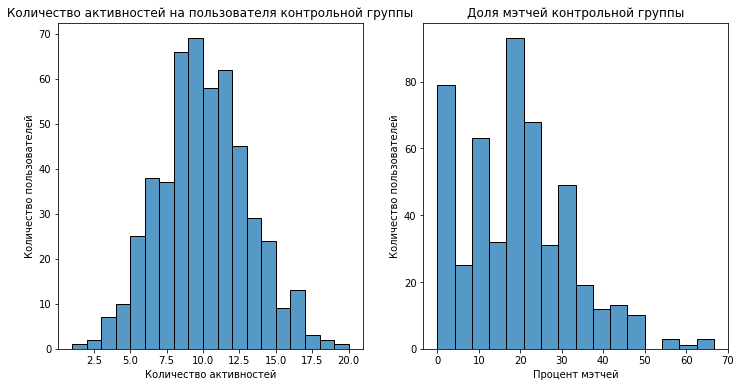

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Первый график - количество активностей
sns.histplot(likes_users_0['likes_0'], ax=axs[0])
axs[0].set_title('Количество активностей на пользователя контрольной группы')
axs[0].set_ylabel('Количество пользователей')
axs[0].set_xlabel('Количество активностей')

# Второй график - процент мэтчей
sns.histplot(likes_users_0['perc_match_0'], ax=axs[1])
axs[1].set_title('Доля мэтчей контрольной группы')
axs[1].set_ylabel('Количество пользователей')
axs[1].set_xlabel('Процент мэтчей')

plt.show()


Пользователи из тестовой группы, которые используют приложение с новым алгоритмом

In [16]:
#посчитаем, сколько лайков приходится на каждого уникального пользователя в тестовой группе (1) 
likes_users_1 = dating_data_df.query('group == 1') \
              .groupby('user_id_1', as_index=False) \
              .agg({'user_id_2':'count', 'is_match':'sum'}) \
              .rename(columns={'user_id_2':'likes_1', 'is_match':'is_match_1'}) \
              .assign(perc_match_1 = lambda x: x['is_match_1'] / x['likes_1'] * 100).round(2) \
              .sort_values('perc_match_1', ascending=False)
likes_users_1.head()

,user_id_1,likes_1,is_match_1,perc_match_1
325,658,18,13,72.22
395,806,14,10,71.43
88,177,21,15,71.43
456,911,20,14,70.00
18,32,23,16,69.57


In [17]:
likes_users_1.describe()

,user_id_1,likes_1,is_match_1,perc_match_1
count,499.000000,499.000000,499.000000,499.000000
mean,503.641283,19.482966,7.833667,40.234569
std,288.590839,2.991489,2.481738,11.410606
min,1.000000,11.000000,0.000000,0.000000
25%,257.500000,18.000000,6.000000,33.330000
50%,509.000000,20.000000,8.000000,40.000000
75%,757.500000,22.000000,9.000000,47.620000
max,1000.000000,29.000000,16.000000,72.220000


В группе пользователей нового алгоритма в среднем на пользователя приходится почти 19.5 активностей, а соотношение мэтчей ко всем лайкам - 40.2 (1 из 2-3 лайков заканчивается взаимным мэтчем). Также у нас есть единичные пользователи, у которых количество активностей больше 22 и процент мэтчей больше 50%. И только 1 пользователь, у которого не было мэтчей в принципе и 11 активностей.

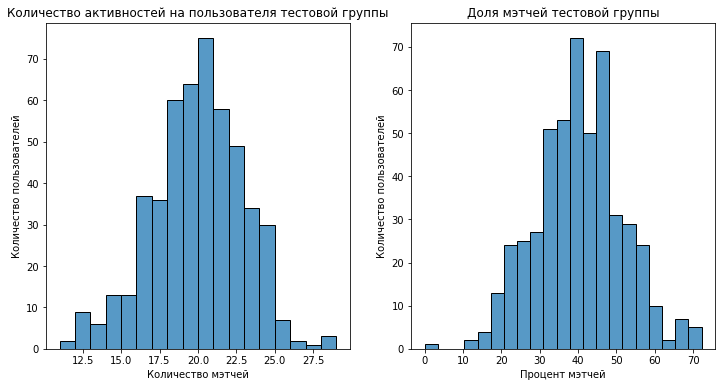

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Первый график - количество мэтчей
sns.histplot(likes_users_1['likes_1'], ax=axs[0])
axs[0].set_title('Количество активностей на пользователя тестовой группы')
axs[0].set_ylabel('Количество пользователей')
axs[0].set_xlabel('Количество мэтчей')

# Второй график - процент мэтчей
sns.histplot(likes_users_1['perc_match_1'], ax=axs[1])
axs[1].set_title('Доля мэтчей тестовой группы')
axs[1].set_ylabel('Количество пользователей')
axs[1].set_xlabel('Процент мэтчей')

plt.show()


In [38]:
#выведем средние обоих групп по количеству активностей и проценту мэтчей
likes_0 = likes_users_0['likes_0'].mean().round(2)
perc_0 = likes_users_0['perc_match_0'].mean().round(2)

likes_1 = likes_users_1['likes_1'].mean().round(2)
perc_1 = likes_users_1['perc_match_1'].mean().round(2)

print('Среднее количество активностей на пользователей контрольной группы:', likes_0)
print('Среднее количество активностей на пользователей тестовой группы:', likes_1)
print('Средняя доля мэтчей на пользователя контрольной группы:', perc_0)
print('Средняя доля мэтчей на пользователя  тестовой группы:', perc_1)

Среднее количество активностей на пользователей контрольной группы: 9.56
Среднее количество активностей на пользователей тестовой группы: 19.48
Средняя доля мэтчей на пользователя контрольной группы: 19.41
Средняя доля мэтчей на пользователя  тестовой группы: 40.23


#### Промежуточные выводы
Предварительно, результаты тестовой группы показывают, что новый алгоритм повысил среднее количество активностей для пользователи почти в 2 раза - с 9.6 активностей до 19.5 активностей. Соотношение мэтчей ко всем действиям пользователя (все поставленные лайки) также увеличилось - с 19.4% до 40.2%. 

- В тестовой группе для пользователя почти половина лайков завершаются взаимным мэтчем при использовании нового алгоритма. 
- В контрольной группе для пользователя только четверть всех лайков завершаются взаимным мэтчем при использовании старого алгоритма. Но требуется статистическая проверка данных, чтобы подтвердить или опровергнуть значимость полученных изменений. 

### Статистические тесты
У нас достаточно большая выборка пользователей, которые относятся к контрольной группе - 501 пользователь. На таком объеме выборки проверка на нормальность распределения не требуется, рассмотрим только на распределение дисперсии (гомогенность двух выборок). Это нужно, чтобы мы в дальнейшем могли использовать t-test для сравнения метрики среднего количества мэтчей на пользователя в двух группах и среднего отношений мэтча ко всем лайкам. Уровень значимости будем рассматривать в 5%
- Нулевая гипотеза при сравнении распределения дисперсий в двух группах по метрике среднего количества активностей дисперсии двух выборок равны, то есть группы имеют гомогенные дисперсии
- Альтернативная гипотеза - дисперсии двух групп отличаются 

In [27]:
# тест Левена
statistic, p_value = levene(likes_users_0['is_match_0'], likes_users_1['is_match_1'])
# Вывод результатов теста
print('Статистика теста Левена:', statistic)
print('p-значение теста Левена:', p_value)

Статистика теста Левена: 134.17424158182058
p-значение теста Левена: 3.3545479435181664e-29


Полученное значение p-value значительно меньше заданного уровня значимости в 5%. Поэтому мы отвергаем нулевую гипотезу и делаем вывод о неоднородности дисперсий между группами. В этом случае мы будем использовать t-критерий Уэлча при проверки гипотезы о разности среднего количества мэтчей в группах

Теперь проверим распределение дисперсий двух групп по метрике соотношение мэтчей ко всем лайкам.  Уровень значимости будем рассматривать в 5% Нулевая гипотеза при сравнении распределения дисперсий в двух группах по метрике среднего соотношения мэтчей ко всем лайкам - дисперсии двух выборок равны, то есть группы имеют гомогенные дисперсии

In [28]:
statistic, p_value = levene(likes_users_0['perc_match_0'], likes_users_1['perc_match_1'])
# Вывод результатов теста
print('Статистика теста Левена:', statistic)
print('p-значение теста Левена:', p_value)

Статистика теста Левена: 10.35301414674427
p-значение теста Левена: 0.001334252506064048


Полученное значение p-value  меньше заданного уровня значимости в 5%. Поэтому мы отвергаем нулевую гипотезу и делаем вывод о неоднородности дисперсий между группами. В этом случае мы будем использовать t-критерий Уэлча при проверки гипотезы среднего соотношения мэтчей ко всем лайкам

### Теперь перейдем к статистической проверке наших продуктовых гипотез

**1. Новый алгоритм предлагает пользователям более подходящие анкеты, чем старый алгоритм. Это увеличило соотношение мэтчей ко всем лайкам за счет того, что пользователи получали взаимный лайк от других быстрее (им требовалось меньше действий, чем пользователям из контрольной группы).**

Мы будем использовать t-критерий Уэлча для проверки гипотезы среднего соотношения мэтчей ко всем лайкам. Уровень значимости - 5%
Нулевая гипотеза - средние значения двух выборок равны. 
Альтернативная гипотеза - есть статистически значимые различия между группами.

In [29]:
statistic, p_value = ttest_ind(likes_users_0['perc_match_0'], likes_users_1['perc_match_1'], equal_var=False)

# Вывод результатов теста
print('Статистика t-критерия Уэлча:', statistic)
print('p-значение t-критерия Уэлча:', p_value)

Статистика t-критерия Уэлча: -26.42772295832559
p-значение t-критерия Уэлча: 1.8186187616685096e-116


P-значение значительно меньше выбранного уровня значимости (менее 5%), то мы отвергаем нулевую гипотезу в пользу альтернативной.
Таким образом, между средними значениями соотношения мэтчей ко всем лайкам контрольной и тестовой группах есть статистически значимые различия. 

Таким образом, новый алгоритм увеличил метрику соотношение мэтчей ко всем лайкам пользователя почти в 2 раза  - 40.2% от всех лайков пользователя заканчиваются взаимным мэтчем, в то время как при использовании старого алгоритма только 19.4% лайков переходили во взаимные мэтчи. Новый алгоритм позволяет пользователям через меньшее количество действий (лайков другим пользователей) познакомиться с другим пользователями. Это может положительно влиять на оценку приложения пользователем и его желание рекомендовать сервис другим потенциальным пользователям.  

**2. Благодаря новому алгоритму среднее число активностей на пользователя увеличилось**

Мы будем использовать t-критерий Уэлча для проверки гипотезы о равенстве среднего количества мэтчей ко всем лайкам в двух группах. Уровень значимости - 5% Нулевая гипотеза - средние значения двух выборок равны. Альтернативная гипотеза - есть статистически значимые различия между группами.

In [30]:
statistic, p_value = ttest_ind(likes_users_0['likes_0'], likes_users_1['likes_1'], equal_var=False)
# Вывод результатов теста
print('Статистика t-критерия Уэлча:', statistic)
print('p-значение t-критерия Уэлча:', p_value)

Статистика t-критерия Уэлча: -51.8560698275145
p-значение t-критерия Уэлча: 2.005368786100045e-285


P-значение значительно меньше выбранного уровня значимости (менее 5%), то мы отвергаем нулевую гипотезу в пользу альтернативной. Таким образом, между средними значениями количества мэтчей  контрольной и тестовой группах есть статистически значимые различия.

### Выводы

Таким образом, новый алгоритм увеличил метрику среднее количество активностей на пользователя в 2 раза - теперь пользователь в среднем совершает 19.5 активностей (=лайков), чем при использовании старого алгоритма (9.6 активностей)
Доля мэтчей пользователя также увеличилась благодаря новому алгоритму - теперь 40% активностей заканчиваются взаимным мэтчем. При использовании старого алгоритма только 19.5% лайков заканчивались взаимным мэтчем. Это может повлять на самооценку пользователя и его уверенность в себе. Позитивные эффекты от приложения могут повясить лояльность пользователя, он будет чаще пользоваться нашим продуктом и оставлять положительные оценки. 
